**Team Members**

Avneesh Nolkha

Ayushee Mittal

Smita Sasindran

Vishesh Sethi



## **Importing Libraries**

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## **Transforms**

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## **Dataset**

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## **Dataloader**

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## **Ghost Batch Normalization classes**

In [5]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)



## **Model**

In [6]:
dropout_value = 0.09
class Net(nn.Module):
    def __init__(self, gbn, gbn_split):
        super(Net, self).__init__()

        self.gbn = gbn
        self.gbn_split = gbn_split

        print("Is GBN run:", gbn)
        # Add BatchNorm or GhostBatchNorm
        def BNLayer(n_features):
            bn = nn.BatchNorm2d(n_features) if not self.gbn else GhostBatchNorm(n_features, self.gbn_split) 
            return bn


        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
            BNLayer(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            BNLayer(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
            nn.BatchNorm2d(10)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(12),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(16),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(20),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## **Model Params**

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(False, 1).to(device)
summary(model, input_size=(1, 28, 28))

cuda
Is GBN run: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
        MaxPool2d-12           [-1, 10, 12, 12]               0
           Conv2d-13           [-1, 10, 10, 10]             900
             ReL

## **Setting up parameters for 5 runs**

In [8]:
run_params = [
  {'model': 'L1_with_BN', 'l1': True, 'l2': False, 'gbn': False, 'gbn_split': 1, 'l_l1': 0.0000085},
  {'model': 'L2_with_BN', 'l1': False, 'l2': True, 'gbn': False, 'gbn_split': 1, 'l_l1': 0},
  {'model': 'L1_and_L2_with_BN', 'l1': True, 'l2': True, 'gbn': False, 'gbn_split': 1, 'l_l1': 0.00000000009},
  {'model': 'GBN', 'l1': False, 'l2': False, 'gbn': True, 'gbn_split': 2, 'l_l1': 0},
  {'model': 'L1_and_L2_with_GBN', 'l1': True, 'l2': True, 'gbn': True, 'gbn_split': 2, 'l_l1': 0.00000000000001}
]
    

In [9]:

train_losses = {}
train_acc = {}
test_losses = {}
test_acc = {}
for rp in run_params:
  train_losses[rp['model']] = []
  train_acc[rp['model']] = []
  test_losses[rp['model']] = []
  test_acc[rp['model']] = []



## **Training and Testing Loops**

In [10]:
from tqdm import tqdm

# train_losses = []
# train_acc = []
# test_losses = []
# test_acc = []

misclassified = []

#{'model': 'L1_with_BN', 'l1': True, 'l2': False, 'gbn': False, 'gbn_split': 1},
def train(model, device, train_loader, optimizer, epoch, params):
  name = params['model']

  model.train()
  pbar = tqdm(train_loader, position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    l1_reg = 0
    l2_reg = 0

    if params['l1']:
      for param in model.parameters():
        l1_reg += param.abs().sum()

    # if params['l2']:
    #   for param in model.parameters():
    #     l2_reg += param.norm(2)

    # Calculate loss
    loss = F.nll_loss(y_pred, target) + params['l_l1'] * l1_reg #+ lambda_l2 * l2_reg

    #train_losses.append(loss)
    train_losses[name].append(loss)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #train_acc.append(100*correct/processed)
    train_acc[name].append(100*correct/processed)
  

def test(model, device, test_loader, params):
    name = params['model']

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)
    test_losses[name].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    #test_acc.append(100. * correct / len(test_loader.dataset))
    test_acc[name].append(100. * correct / len(test_loader.dataset))

    

## **Running the models**

In [11]:
models = {}

optim_params = {
  'L1_with_BN':        {'lr':0.025, 'step_size': 12,'gamma': 0.2, 'weight_decay': 0},
  'L2_with_BN':        {'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0.000095},
  'L1_and_L2_with_BN': {'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0.000009},
  'GBN':               {'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0},
  'L1_and_L2_with_GBN':{'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0.0000001} 
}


for i, rp in enumerate(run_params):
    name = rp['model']
    opt = optim_params[name]
    print("\n\n ******** Running for: ", name, "====================================================")
    model =  Net(rp['gbn'], rp['gbn_split']).to(device)
    
    #optimizer = optim.SGD(model.parameters(), lr=0.0180, momentum=0.92)
    optimizer = optim.SGD(model.parameters(), lr=opt['lr'], momentum=0.9, weight_decay=opt['weight_decay'])
    scheduler = StepLR(optimizer, step_size=opt['step_size'], gamma=opt['gamma'])

    models[name] = model

    EPOCHS = 25
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch+1)
        train(model, device, train_loader, optimizer, epoch, rp)
        scheduler.step()
        test(model, device, test_loader, rp)


  0%|          | 0/469 [00:00<?, ?it/s]



 ******** Running for:  L1_with_BN ====================================================
Is GBN run: False
EPOCH: 1


Loss=0.16970933973789215 Batch_id=468 Accuracy=90.74: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.09658050537109375 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.07129324227571487 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.06221919506788254 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.09831634908914566 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.02460932731628418 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.08888830989599228 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.03465050086379051 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.09611067175865173 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.012981785461306572 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.08324089646339417 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.02004539966583252 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.0712633728981018 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.01763000339269638 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.04764033481478691 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.014264119789004326 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.02856164239346981 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.009815159253776073 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.02999270334839821 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.02637755125761032 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.028327669948339462 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 22


Loss=0.02076868712902069 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.01989126205444336 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9949/10000 (99.49%)

EPOCH: 24


Loss=0.01745595410466194 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9950/10000 (99.50%)

EPOCH: 25


Loss=0.033173151314258575 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)



 ******** Running for:  L2_with_BN ====================================================
Is GBN run: False
EPOCH: 1


Loss=0.19346795976161957 Batch_id=468 Accuracy=90.61: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9818/10000 (98.18%)

EPOCH: 2


Loss=0.07795282453298569 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:13<00:00, 35.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9842/10000 (98.42%)

EPOCH: 3


Loss=0.13764148950576782 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.049399182200431824 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


Loss=0.034031759947538376 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.03353825584053993 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.02796234004199505 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.03268913924694061 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.04881707951426506 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.05114399269223213 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.00981215387582779 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.02267122082412243 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.006836895365267992 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.012700699269771576 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.08389848470687866 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.011848379857838154 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.031006885692477226 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.012738198973238468 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.06705037504434586 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.05701485276222229 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.06099790707230568 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.08374346047639847 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


Loss=0.06623262166976929 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.02261834591627121 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.04459823668003082 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)



 ******** Running for:  L1_and_L2_with_BN ====================================================
Is GBN run: False
EPOCH: 1


Loss=0.11845023185014725 Batch_id=468 Accuracy=90.00: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0620, Accuracy: 9817/10000 (98.17%)

EPOCH: 2


Loss=0.06738975644111633 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.05401187017560005 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.07394146174192429 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.027715696021914482 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.013737966306507587 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.011566657572984695 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 8


Loss=0.010870506055653095 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.01590302400290966 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.033957336097955704 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.024981053546071053 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.07961906492710114 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.0037445933558046818 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.04765404015779495 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.04593675956130028 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.008157557807862759 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.0055323936976492405 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.013363265432417393 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.10970854759216309 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.004433794412761927 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.08374065160751343 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


Loss=0.021260008215904236 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.023454228416085243 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.012119803577661514 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.07984954118728638 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)



 ******** Running for:  GBN ====================================================
Is GBN run: True
EPOCH: 1


Loss=0.07507826387882233 Batch_id=468 Accuracy=89.02: 100%|██████████| 469/469 [00:13<00:00, 35.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9793/10000 (97.93%)

EPOCH: 2


Loss=0.055935487151145935 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9786/10000 (97.86%)

EPOCH: 3


Loss=0.029291847720742226 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


Loss=0.03525007888674736 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.06632743775844574 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 34.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.006874082610011101 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.010441419668495655 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 34.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.04422694072127342 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.05975737050175667 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.03337618336081505 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.044304218143224716 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.03582039847970009 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.012213603593409061 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 35.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.05024213716387749 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.006085911765694618 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.011827611364424229 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.0031637398060411215 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.13021345436573029 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.05048563703894615 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Loss=0.07146430015563965 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.04991178214550018 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.03751141577959061 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.024777693673968315 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.036388471722602844 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:12<00:00, 36.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 25


Loss=0.035519082099199295 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)



 ******** Running for:  L1_and_L2_with_GBN ====================================================
Is GBN run: True
EPOCH: 1


Loss=0.12144569307565689 Batch_id=468 Accuracy=90.68: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Loss=0.055600885301828384 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0619, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.02420809306204319 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.0684051439166069 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.018275190144777298 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


Loss=0.07099617272615433 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.005996156483888626 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.035754770040512085 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.06731497496366501 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.07022226601839066 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.004920704755932093 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.012523514218628407 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.030846690759062767 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.024514464661478996 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.044686753302812576 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.07436082512140274 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.03246789425611496 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.04706388711929321 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.0238711629062891 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.005932170432060957 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.026523396372795105 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.024180160835385323 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.0245943795889616 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.007023641373962164 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.022939348593354225 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]



Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)



## **Plotting functions**

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import files

def plot_with_legends(run_params, data, title):
    figure = plt.figure()
    #figure.suptitle(title, fontsize=16)
    plt.figure(figsize=(15,8))
    
    for i, pld in enumerate(run_params):
        name = pld['model']
        plt.plot(data[name], label=name)

    plt.legend()
    plt.title(title)
    fname = name + "_" + title  
    plt.savefig(fname + ".png")
    files.download(fname + ".png") 
    plt.show()  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

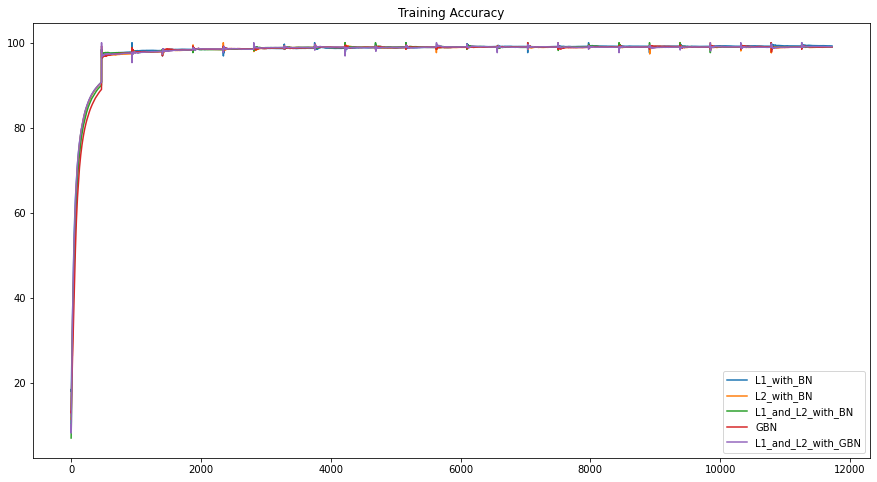

In [13]:
plot_with_legends(run_params, train_acc, 'Training Accuracy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

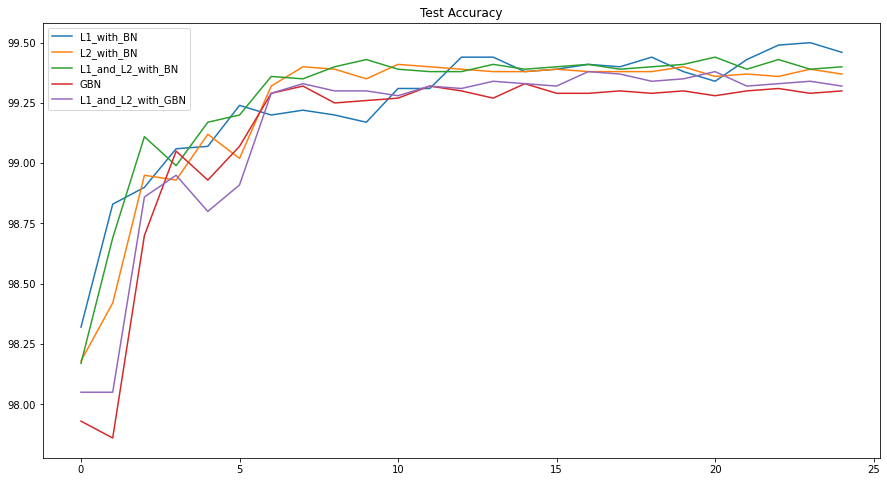

In [14]:

plot_with_legends(run_params, test_acc, 'Test Accuracy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

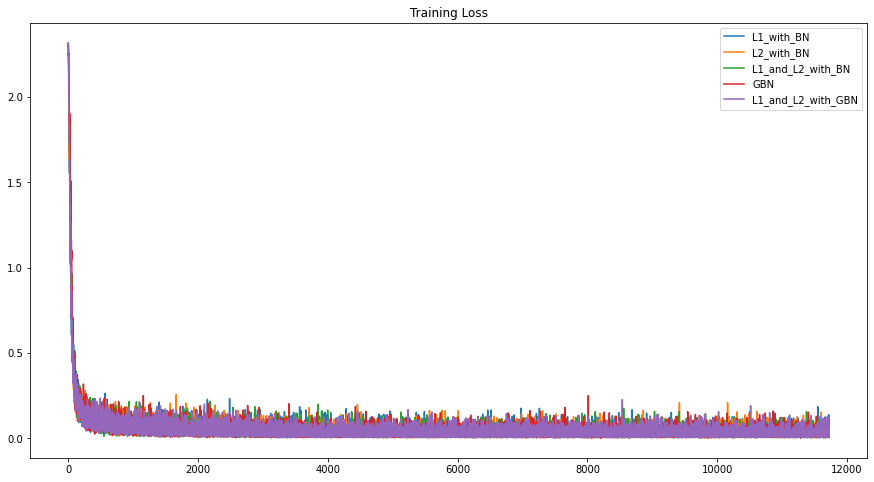

In [15]:
plot_with_legends(run_params, train_losses, 'Training Loss')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

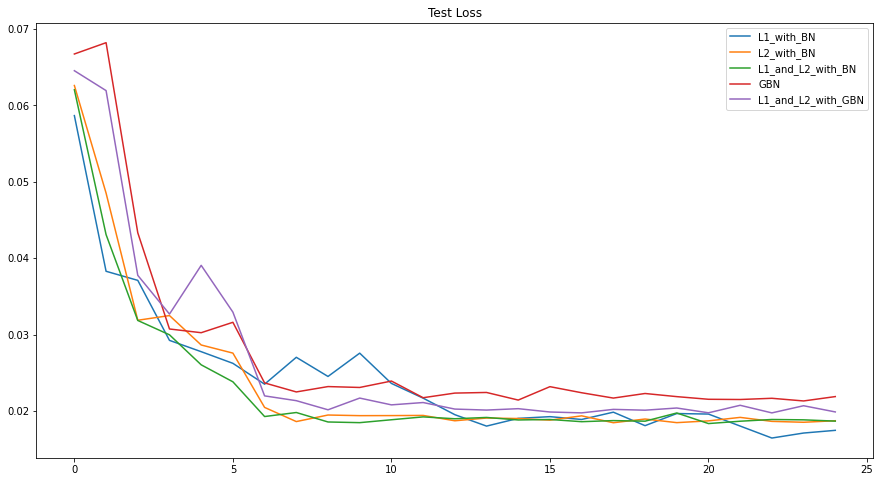

In [16]:
plot_with_legends(run_params, test_losses, 'Test Loss')

## **Misclassified Images with GBN**

In [17]:
gbn_model = models['GBN']


incorrect_indexes = {} # {23: {'actual': 1, 'predicted': 4}}
gbn_model.eval()
count = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = gbn_model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        for sampleno in range(data.shape[0]):
                if(target[sampleno]!=pred[sampleno]):
                    count += 1
                    #print("Index=", sampleno, ", Actual=", target[sampleno].cpu().numpy(), ", Predicted: ", pred[sampleno].cpu().numpy()[0])
                    incorrect_indexes[sampleno] = {'actual': target[sampleno].cpu().numpy(), 
                                                   'predicted': pred[sampleno].cpu().numpy()[0], 
                                                   'data': data[sampleno].cpu().numpy()}

#print(incorrect_indexes) 
print(len(incorrect_indexes))
print(count)

49
70


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

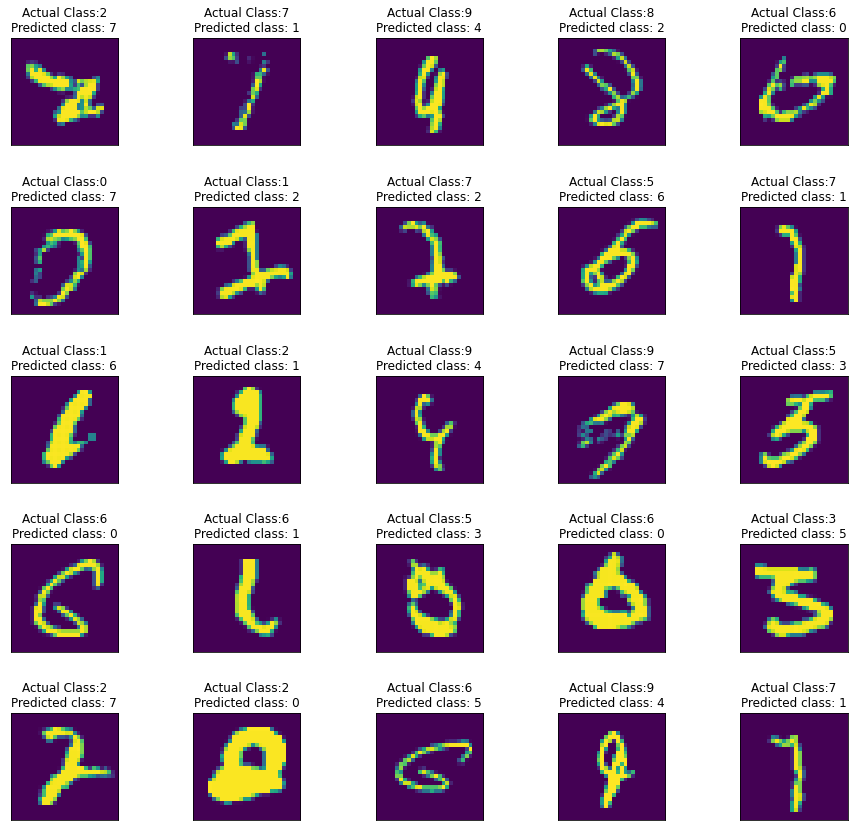

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

#{23: {'actual': 1, 'predicted': 4}}
x = 0
y = 0
fig, axs = plt.subplots(5, 5, figsize = (15, 15))
plt.setp(axs, xticks=[], yticks=[])
fig.subplots_adjust(wspace=0.7)
images = list(incorrect_indexes.items())[:25]
for index, results in images:
  #print(index)
  img = results['data'] 
  img = np.squeeze(img)
  actual_class = results['actual'] 
  predicted_class =  results['predicted'] 

  plt.savefig("misclassified.png")
  files.download("misclassified.png")  
  axs[x, y].imshow(img)
  axs[x, y].set_title('Actual Class:' + str(actual_class) + "\nPredicted class: " + str(predicted_class))
  
  if y == 4:
    x += 1
    y = 0
  else:
    y += 1

plt.savefig("misclassified.png")
files.download("misclassified.png")     